# 1.-Introduction

For this learning path I will be following the documentation webpage of Keras written by François Chollet and I will play a bit with the code to understand things better.

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

In [4]:
import tensorflow as tf  
from tensorflow import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


train_ds = tfds.load('coil100', split='train', batch_size=-1)
train_ds.keys()

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


dict_keys(['image', 'label', 'object_id'])

In [5]:
x_train, x_test = np.array([img/ 255 for img in train_ds['image'][:6000]]), np.array([img/ 255 for img in train_ds['image'][6000:]])
del train_ds

x_train.shape, x_test.shape

((6000, 128, 128, 3), (1200, 128, 128, 3))

# 2.- Model Definition

In [6]:
input_dim = (128, 128, 3)

import keras
from keras import layers

Since we are using normalized inputs and we are comparing provabilities we are using binary_crossentropy as loss. To do so, we had to normalize the input data in order to be able to compute probabilities with binary crossentropy. We could also use mse as loss and get same good results. This would be a good approach to compare CNN AutoEncoders with dense AutoEncoders we made on previous NBs, but the correct approach is this one. 

We can not do **decoder = keras.Model(encoded_img , decoded_img, name='decoder')** because it does not recieve an input object.


In [8]:
from keras.callbacks import ModelCheckpoint
class reduce_prints(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 25 ==0:
            print(f"Epoch {epoch}: Loss is: {logs['loss']}")
rp = reduce_prints()


filepath = "Conv_AutoEnc.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
desired_callbacks = [checkpoint, rp]


In [9]:
encoder_input_img = keras.Input(shape= input_dim)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)
encoded_img = layers.MaxPooling2D((2, 2), padding='same')(x)
encoder = keras.Model(encoder_input_img, encoded_img, name='encoder')
encoder.summary()

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_img)
x = layers.UpSampling3D((2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling3D((2))(x)
decoded_img  = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = keras.Model(encoder_input_img, decoded_img, name='Auto-encoder')
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test), verbose = 0, callbacks = desired_callbacks)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 3)         867       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 3)         0         
Total params: 1,763
Trainable params: 1,763
Non-trainable params: 0
_________________________________________________________________
Model: "Auto-encoder"
_________________________________________________________________
Layer (type)                 Output

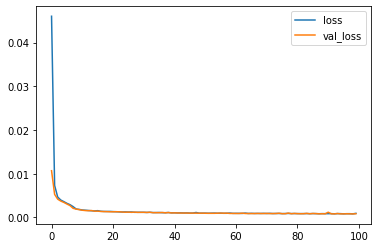

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

# 3.- Results
## 3.1.- What is Encoding learning?


Firstly, we will begin by checking what is encoder doing. In order to be able to represent the 3 RGB original channels I will use a layer with 3 filters for the encoder  in order to generate images with the 3 channels.

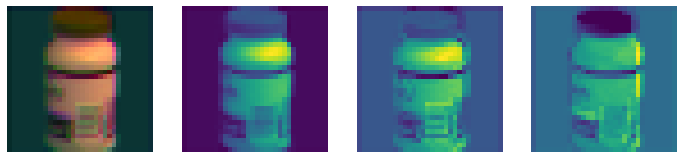

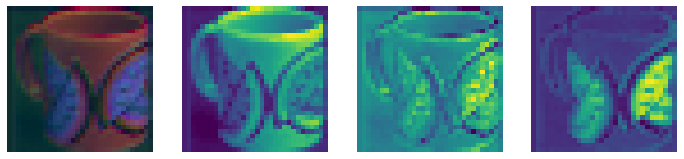

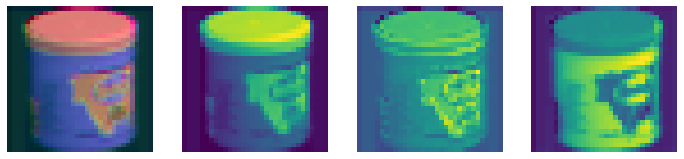

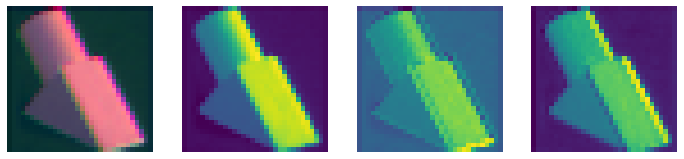

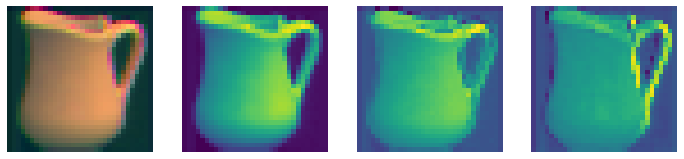

In [11]:
n_imgs = np.random.randint(x_test.shape[0])
enc_imgs = encoder.predict(x_test[n_imgs: n_imgs + 5].reshape(-1, 128, 128, 3))

for enc in enc_imgs:
  fig, ax = plt.subplots(1, 4, figsize=(12,12))
  channels = [enc[:, :, c] for c in range(enc.shape[2])]
  ax[0].imshow(enc)
  ax[0].axis('off')
  ax[1].imshow(channels[0])
  ax[1].axis('off')
  ax[2].imshow(channels[1])
  ax[2].axis('off')
  ax[3].imshow(channels[2])
  ax[3].axis('off')
  plt.show()
  print(" ")

## 3.2.- Image Decoding

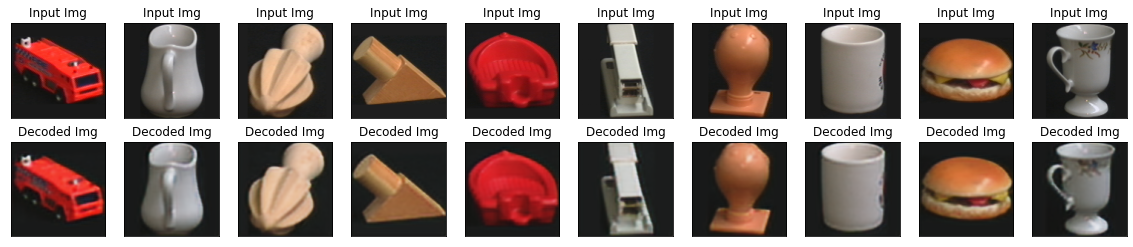

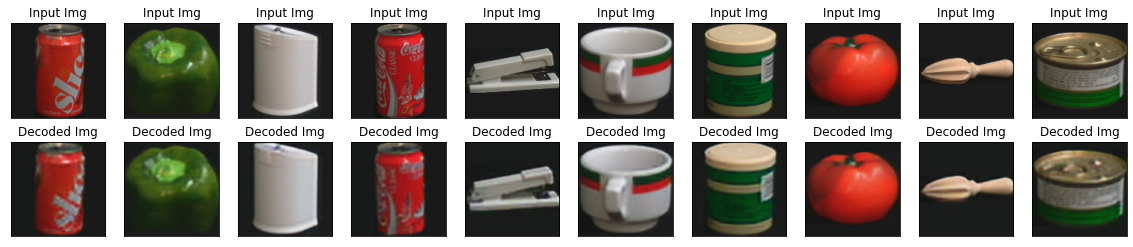

In [12]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(128, 128, 3))
    plt.title('Input Img')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128, 3))
    plt.title('Decoded Img')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print(" ")

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[n + i].reshape(128, 128, 3))
    plt.title('Input Img')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[n + i].reshape(128, 128, 3))
    plt.title('Decoded Img')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As we can see, the loss of information is quite little but still exists. This might be because loss function should be decreased closer to 0. In order to achieve this, we should keep training and maybe use a Learning Rate scheduler to capture the most fine-grained deatils and a more complicated Architecture.

Let us compute how much are we compressing images in order to fully understand the process.

In [17]:
original_size = 128 * 128 * 3
compressed_size = 32 * 32 * 3

print(f" % of compression ---> {100 - 100 * compressed_size / original_size}")

 % of compression ---> 93.75


# 4.- Application to IMAGE DENOISING

Now, as in previous works I will add some noise randomly to some images and see how do this Conv Autoencoder perform with that task.

In [25]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

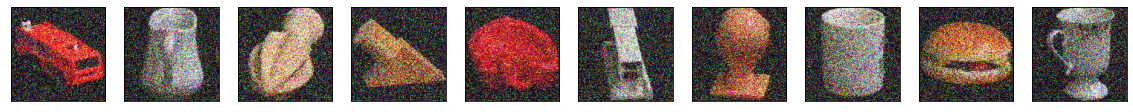

In [26]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(128, 128, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [27]:
filepath = "Conv_AutoEnc_denoised.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
desired_callbacks = [checkpoint, rp]


In [31]:
encoder_input_img = keras.Input(shape= input_dim)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)
encoded_img = layers.MaxPooling2D((2, 2), padding='same')(x)
encoder_d = keras.Model(encoder_input_img, encoded_img, name='encoder')


x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_img)
x = layers.UpSampling3D((2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling3D((2))(x)
decoded_img  = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder_d = keras.Model(encoder_input_img, decoded_img, name='Denoising-Auto-encoder')
autoencoder_d.compile(optimizer='adam', loss='mse')


history_d = autoencoder_d.fit(x_train_noisy, x_train, 
                epochs=80,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test_noisy, x_test), verbose = 0, callbacks = desired_callbacks)

Epoch 0: Loss is: 0.017498891800642014
Epoch 25: Loss is: 0.0019329264760017395
Epoch 50: Loss is: 0.0017262136097997427
Epoch 75: Loss is: 0.0016432205447927117


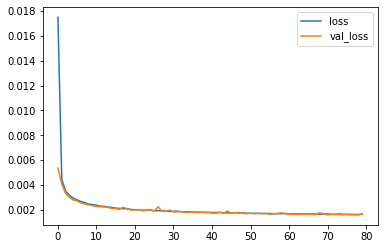

In [37]:
plt.plot(history_d.history['loss'])
plt.plot(history_d.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
n_imgs = np.random.randint(x_test.shape[0])
enc_imgs = encoder.predict(x_test[n_imgs: n_imgs + 5].reshape(-1, 128, 128, 3))

for enc in enc_imgs:
  fig, ax = plt.subplots(1, 4, figsize=(12,12))
  channels = [enc[:, :, c] for c in range(enc.shape[2])]
  ax[0].imshow(enc)
  ax[0].axis('off')
  ax[1].imshow(channels[0])
  ax[1].axis('off')
  ax[2].imshow(channels[1])
  ax[2].axis('off')
  ax[3].imshow(channels[2])
  ax[3].axis('off')
  plt.show()
  print(" ")

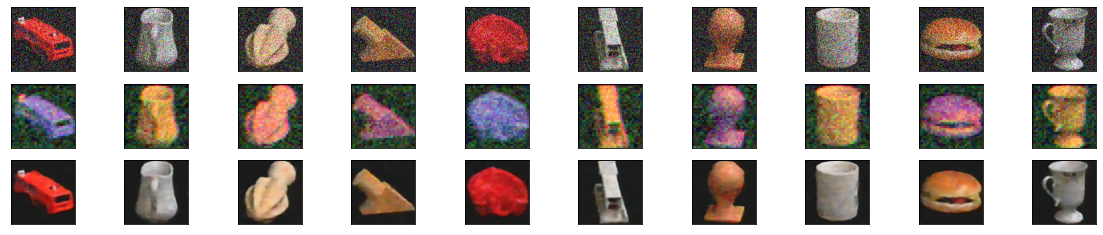

In [53]:
decoded_imgs = autoencoder_d.predict(x_test_noisy)
enc_imgs = encoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test_noisy[i].reshape(128, 128, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + n)
    plt.imshow(enc_imgs[i].reshape(32, 32, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i + n + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128, 3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

plt.show()
print(" ")


We can see on the plotting above what is the effect of the encoder for the input noisy images and how well the cleaning autoencoder performs, which is 10/10.

# 5.- Conclusions

We have tested how do Convolutional AutoEncoders work with images. We have seen that they perform way better than Dense AutoEncoders as we could expect
because we can see that images decoded are better, loss function decreasing is more stable and model is not introducing strange effects such as the "movement effect"
we saw on previous notebooks. Also, the compression factor is similar, because this is something we can choose as the output filters of the last Conv Layer
of the encoder.

We have also used them to perform image denoising and we have seen they work perfectly for the purpose of cleaning the images.

For all this reasons, Conv AutoEncoders might be a very good approach for performing image denoising and an alternative to be taken into account for compressing images but it is true that there are already many classics methods based on interpolation that are indeed less costly and more simple.